[View in Colaboratory](https://colab.research.google.com/github/MarcinWylot/CryptocurrencyPricePredictor/blob/master/BitcoinPredictWithLSTM.ipynb)

In [0]:
import requests
import json
import calendar
import random 
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error, mean_absolute_error


In [51]:
url = 'https://min-api.cryptocompare.com/data/histohour?tsym=USD&limit=9999&fsym=BTC'
response = requests.get(url)

json_array = json.loads(response.text)

df = pd.DataFrame(json_array['Data'], columns = ['time', 'close', 'high', 'low', 'open', 'volumefrom','volumeto'])
#df.drop('time', 1, inplace=True)
df.set_index('time', inplace=True)
  
df.head()

,close,high,low,open,volumefrom,volumeto
time,,,,,,
1525824000,9138.61,9204.71,9137.56,9196.13,2460.45,22619904.40
1525827600,9173.02,9179.73,9137.50,9138.62,977.43,8989864.00
1525831200,9094.69,9175.21,9089.32,9172.57,3371.70,30818549.21
1525834800,9056.42,9094.75,9016.16,9094.69,6559.13,59468539.57
1525838400,9086.62,9090.16,8987.27,9056.42,5624.84,50897503.62


In [52]:
nb_features = df.shape[1]
df.shape

(2001, 6)

In [53]:
df.iloc[:5,0:6]

,close,high,low,open,volumefrom,volumeto
time,,,,,,
1525824000,9138.61,9204.71,9137.56,9196.13,2460.45,22619904.40
1525827600,9173.02,9179.73,9137.50,9138.62,977.43,8989864.00
1525831200,9094.69,9175.21,9089.32,9172.57,3371.70,30818549.21
1525834800,9056.42,9094.75,9016.16,9094.69,6559.13,59468539.57
1525838400,9086.62,9090.16,8987.27,9056.42,5624.84,50897503.62


In [0]:
def load_data(X, seq_len, train_size=0.9):
    amount_of_features = X.shape[1]
    X_mat = X.as_matrix()
    sequence_length = seq_len + 1
    data = []
    
    for index in range(len(X_mat) - sequence_length):
        data.append(X_mat[index: index + sequence_length])
    
    data = np.array(data)
    train_split = int(round(train_size * data.shape[0]))
    train_data = data[:train_split, :]
    
    x_train = train_data[:, :-1]
    y_train = train_data[:, -1][:,0]
    
    x_test = data[train_split:, :-1] 
    y_test = data[train_split:, -1][:,0]

    return x_train, y_train, x_test, y_test

In [0]:
def load_data2(X, seq_len, train_size=0.9):
  df_s = X.copy()  
  for i in range(seq_len):
    df_s = pd.concat([df_s, X.shift(-(i+1))], axis = 1) 
    
  df_s.dropna(axis=0, inplace=True)
  
  X = df_s.iloc[:,6:]  
  y = df_s.iloc[:,0]
  
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=1-train_size, random_state=32, shuffle=False)
 
  return x_train, y_train, x_test, y_test

In [71]:
window = 5
X_train, y_train, X_test, y_test = load_data2(df, window)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(1796, 30) (200, 30) (1796,) (200,)


In [77]:
scaler = MinMaxScaler()
#X_train_scaled = scaler.fit_transform(X_train.reshape(-1,X_train.shape[2]))
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = X_train_scaled.reshape(X_train.shape[0], window, nb_features)

#X_test_scaled = scaler.transform(X_test.reshape(-1,X_test.shape[2]))
X_test_scaled = scaler.transform(X_test)
X_test_scaled = X_test_scaled.reshape(X_test.shape[0], window, nb_features)

print(X_train_scaled.shape, X_test_scaled.shape)


(1796, 5, 6) (200, 5, 6)


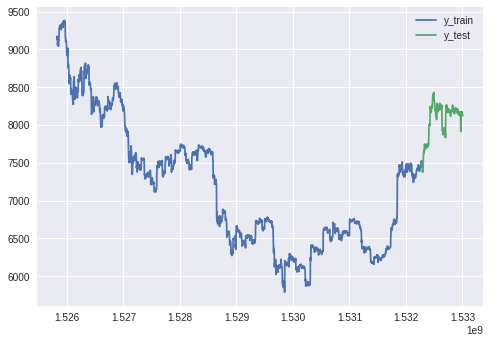

In [75]:
plt.plot(y_train, label='y_train')
plt.plot(y_test, label='y_test')
plt.legend(loc='best')
plt.show()

In [0]:
neurons = 128 #512                 
activation_function = 'tanh' 
dropout = 0.2 #0.25     
loss = 'mse'                  
optimizer="adam"              
            
batch_size = 100               
epochs = 200                                 
training_size = 0.8


def nn_model(input_shape=(window, nb_features), output_size=1, neurons=neurons, activ_func=activation_function, dropout=dropout, loss=loss, optimizer=optimizer):
  model = Sequential()
  
  model.add(LSTM(neurons, return_sequences=True, input_shape=input_shape))
  model.add(Dropout(dropout))
  
  #model.add(LSTM(neurons, return_sequences=True, activation=activ_func))
  #model.add(Dropout(dropout))
  
  model.add(LSTM(neurons, return_sequences=False))
  model.add(Dropout(dropout))
  
  #model.add(Dense(units=output_size))
  #model.add(Activation(activ_func))
  model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
  model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
  
  model.compile(loss=loss, optimizer=optimizer, metrics=['mse'])
#  model.summary()
  return model

def nn_model2(input_shape=(window, nb_features)):
    d = 0.2
    model = Sequential()
    
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(128, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    model.compile(loss='mse',optimizer='adam', metrics=['mse'])
    
#    model.summary()
    return model
  
# random seed for reproducibility
np.random.seed(32)
# initialise model architecture
model = nn_model()

In [97]:
model.fit(X_train_scaled, y_train, batch_size=100, epochs=200, verbose=0)


trainPredict = pd.Series(model.predict(X_train_scaled)[:,0], index=y_train.index.copy())
testPredict = pd.Series(model.predict(X_test_scaled)[:,0], index=y_test.index.copy())

trainScore = mean_squared_error(y_train, trainPredict) ** .5
print('Train Score: %.2f RMSE' % (trainScore))
testScore = mean_squared_error(y_test, testPredict) ** .5
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 116.67 RMSE
Test Score: 83.81 RMSE


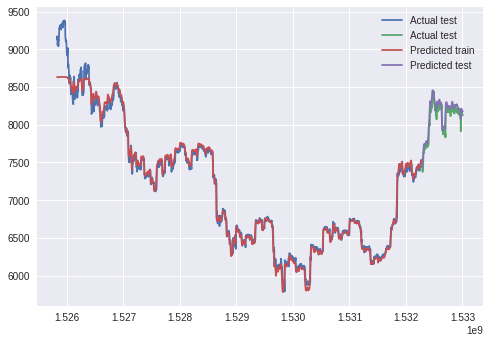

In [98]:
plt.plot(y_train, label='Actual test')
plt.plot(y_test, label='Actual test')
plt.plot(trainPredict, label='Predicted train')
plt.plot(testPredict, label='Predicted test')
plt.legend(loc='best')
plt.show()